# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

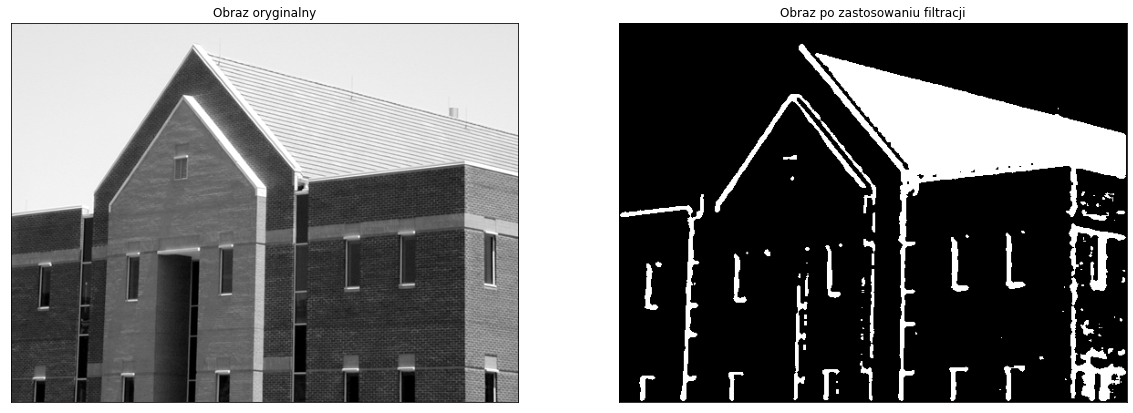

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

dom = cv2.imread("dom.png")          
dom = cv2.cvtColor(dom, cv2.COLOR_BGR2GRAY)

gaussianblur = cv2.GaussianBlur(dom, (3, 3), 0)
laplasjan = cv2.Laplacian(gaussianblur, cv2.CV_32F)

def crossing(LoG, thr):
  x, y = LoG.shape
  tab = np.ones((x,y)) 
  for i in range(1, x - 1):
    for j in range(1, y - 1):
      surr = LoG[(i-1):(i+2), (j-1):(j+2)]
      max = np.max(surr)
      min = np.min(surr)
      if LoG[i][j] > 0:
        tab[i][j] = LoG[i][j] + np.abs(min)
      elif LoG[i][j] < 0:
        tab[i][j] = np.abs(LoG[i][j]) + max
  tab = tab/(tab.max()/255.0)
  tab = tab.astype('uint8')
  threshold, tab = cv2.threshold(tab, thr, 255, cv2.THRESH_OTSU)
  tab = tab.astype('uint8')
  tab = cv2.medianBlur(np.float32(tab), 5)
  return tab

out = crossing(laplasjan, 30)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
plt.subplot(121),plt.imshow(dom),plt.title('Obraz oryginalny')
plt.xticks([]), plt.yticks([])
plt.gray()
plt.subplot(122),plt.imshow(out ),plt.title('Obraz po zastosowaniu filtracji')
plt.xticks([]), plt.yticks([])
plt.gray()
plt.show()

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj pierwszą część algorytmu detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
7. Na jednym obrazie zaznacz piksele należące do obrazu $g_{NH}$ jako czerwone oraz należące do obrazu $g_{NL}$ jako niebieskie.
Wyświetl obraz.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 556.5, 416.5, -0.5)

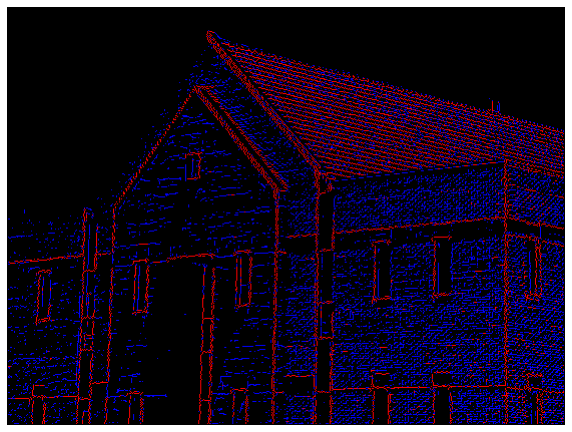

In [ ]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 

M = fgaussian(5, 0.5)
gauss_filter = cv2.filter2D(dom, -1, M)

S1 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],np.float32)/9.0
S2 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]],np.float32)/9.0

gx = cv2.filter2D(gauss_filter,-1, S1)
gy = cv2.filter2D(gauss_filter,-1, S2)

M_xy = np.sqrt((gx**2)+(gy**2))
M_xy = M_xy/(M_xy.max()/255.0)
M_xy = M_xy.astype('uint8')
alfa = np.arctan2(gy, gx)

x, y = M_xy.shape
tab = np.zeros((x,y), dtype=np.int32)
angle = alfa * 180. / np.pi
angle[angle < 0] += 180
for i in range(1,x-1):
  for j in range(1,y-1):
    v = 255
    h = 255


    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
        v = M_xy[i, j+1]
        h = M_xy[i, j-1]

    elif (22.5 <= angle[i,j] < 67.5):
        v = M_xy[i+1, j-1]
        h = M_xy[i-1, j+1]

    elif (67.5 <= angle[i,j] < 112.5):
        v = M_xy[i+1, j]
        h = M_xy[i-1, j]

    elif (112.5 <= angle[i,j] < 157.5):
        v = M_xy[i-1, j-1]
        h = M_xy[i+1, j+1]

    if (M_xy[i,j] < v) or (M_xy[i,j] < h):
        tab[i,j] = 0
    else:
        tab[i,j] = M_xy[i,j]

x, y = tab.shape

Tl = 50
Th = 150

gnl = np.zeros((x, y), dtype=np.int32)
gnh = np.zeros((x, y), dtype=np.int32)

Thx, Thy = np.where(tab >= Th)
Tlx, Tly = np.where((tab < Th) & (tab > Tl))

gnh[Thx, Thy] = 255
gnl[Tlx, Tly] = 255

x, y = dom.shape
out = np.zeros((x,y,3))
out[:,:,0] = gnh
out[:,:,2] = gnl

fig, axs = plt.subplots()
fig.set_size_inches(10, 10)
axs.imshow(out)
axs.axis('off')


## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z wykonaną częściową implementacją w poprzednim ćwiczeniu.
Na czym polegają różnice?

(-0.5, 556.5, 416.5, -0.5)

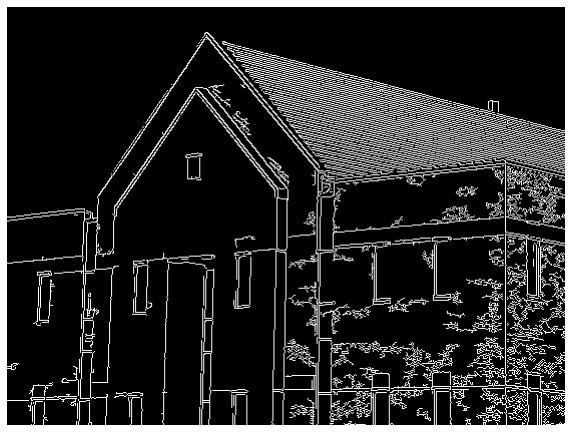

In [ ]:
dom = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

dom_fil = cv2.Canny(dom, 50, 150, None, 3, 1)

fig, axs = plt.subplots()
fig.set_size_inches(10, 10)
axs.imshow(dom_fil, "gray")
axs.axis('off')